# Course Lead Scoring - Evaluation

## Load the data

In [66]:
# Read dataset
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

data = 'course_lead_scoring.txt'
df = pd.read_csv(data)
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


## Data preparation
- Check if the missing values are presented in the features.
- If there are missing values:
  - For caterogiral features, replace them with 'NA'
  - For numerical features, replace with with 0.0

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [67]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [68]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [69]:
# Fill missing values
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna('NA')
    else:
        df[col] = df[col].fillna(0.0)

In [70]:
# Split data into train/validation/test sets
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)  # 0.25 x 0.8 = 0.2

y_train = df_train['converted'].values
y_val = df_val['converted'].values
y_test = df_test['converted'].values

del df_train['converted']
del df_val['converted']
del df_test['converted']

df_train.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score
462,events,manufacturing,2,95543.0,unemployed,europe,3,0.78
135,referral,NA,1,54924.0,student,south_america,6,0.39
117,organic_search,healthcare,2,77352.0,unemployed,europe,2,0.22
1051,paid_ads,other,2,34600.0,employed,south_america,2,0.31
945,paid_ads,education,0,43615.0,unemployed,south_america,2,0.01


### Question 1: ROC AUC feature importance
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that
- For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
- Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['balance'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?
- lead_score
- number_of_courses_viewed
- interaction_count
- annual_income

In [71]:
# List of numerical columns
num_cols = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']
auc_scores = {}

for col in num_cols:
    score = df_train[col].values
    auc = roc_auc_score(y_train, score)
    # If AUC < 0.5, invert the variable
    if auc < 0.5:
        auc = roc_auc_score(y_train, -score)
    auc_scores[col] = round(auc, 3)
auc_scores

{'lead_score': 0.614,
 'number_of_courses_viewed': 0.764,
 'interaction_count': 0.738,
 'annual_income': 0.552}

### Question 2: Training the model
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

`LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`

What's the AUC of this model on the validation dataset? (round to 3 digits)
- 0.32
- 0.52
- 0.72
- 0.92

In [72]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(df_train.to_dict(orient='records'))
X_val = dv.transform(df_val.to_dict(orient='records'))

# Train logistic regression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)
model.fit(X_train, y_train)

# Predict probabilities and compute AUC
y_val_pred = model.predict_proba(X_val)[:,1]
auc = roc_auc_score(y_val, y_val_pred)
print("Validation AUC:", round(auc, 3))

Validation AUC: 0.817


### Question 3: Precision and Recall
Now let's compute precision and recall for our model.
- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

At which threshold precision and recall curves intersect?
- 0.145
- 0.345
- 0.545
- 0.745

C:\Users\My Pham\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\My Pham\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\My Pham\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


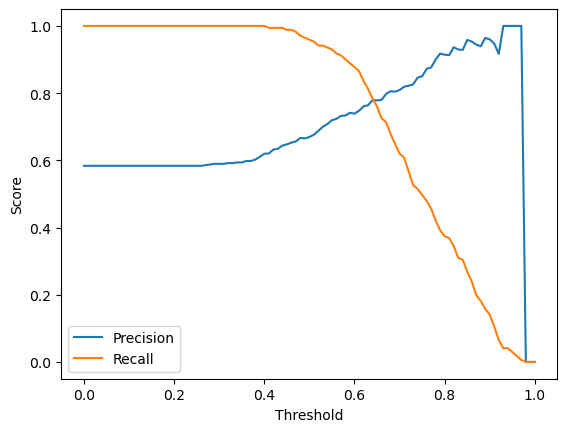

Intersection threshold: 0.98


In [73]:
# probabilities for the positive class
y_val_pred_proba = model.predict_proba(X_val)[:, 1]  

thresholds = np.arange(0, 1.01, 0.01)
precisions = []
recalls = []

for t in thresholds:
    y_pred = (y_val_pred_proba >= t).astype(int)
    precisions.append(precision_score(y_val, y_pred))
    recalls.append(recall_score(y_val, y_pred))

# Plot
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

# Find threshold where precision ≈ recall
diff = np.abs(np.array(precisions) - np.array(recalls))
threshold_intersect = thresholds[np.argmin(diff)]
print("Intersection threshold:", threshold_intersect)

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:
$$
F_1 = \frac{2 \cdot P \cdot R}{P + R}
$$
Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?
- 0.14
- 0.34
- 0.54
- 0.74

In [74]:
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for t in thresholds:
    y_pred = (y_val_pred_proba >= t).astype(int)
    f1_scores.append(f1_score(y_val, y_pred))

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print("Best threshold:", best_threshold)
print("Max F1 score:", best_f1)

Best threshold: 0.5700000000000001
Max F1 score: 0.8124999999999999


### Question 5: 5-Fold CV
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

`KFold(n_splits=5, shuffle=True, random_state=1)`

- Iterate over different folds of df_full_train
- Split the data into train and validation
- Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
- Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?
- 0.0001
- 0.006
- 0.06
- 0.36

In [76]:
df_full_train = df_train_full.reset_index(drop=True)
y_full_train = df_full_train['converted'].values
df_full_train = df_full_train.drop(columns=['converted'])

kf = KFold(n_splits=5, shuffle=True, random_state=1)
auc_scores = []

for train_idx, val_idx in kf.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    y_train = y_full_train[train_idx]
    y_val = y_full_train[val_idx]
    
    # One-hot encoding
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(df_train.to_dict(orient='records'))
    X_val = dv.transform(df_val.to_dict(orient='records'))
    
    # Train logistic regression
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    # Predict probabilities and compute AUC
    y_val_pred_proba = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_val_pred_proba)
    auc_scores.append(auc)

# Standard deviation of AUC across folds
std_auc = np.std(auc_scores)
print("Standard deviation of AUC:", round(std_auc, 3))

Standard deviation of AUC: 0.036


### Question 6: Hyperparameter Tuning
Now let's use 5-Fold cross-validation to find the best parameter C
- Iterate over the following C values: [0.000001, 0.001, 1]
- Initialize KFold with the same parameters as previously
- Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?
- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.

In [77]:
C_values = [0.000001, 0.001, 1]
kf = KFold(n_splits=5, shuffle=True, random_state=1)

results = {}

for C in C_values:
    auc_scores = []
    
    for train_idx, val_idx in kf.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        y_train = y_full_train[train_idx]
        y_val = y_full_train[val_idx]

        # One-hot encoding
        dv = DictVectorizer(sparse=False)
        X_train = dv.fit_transform(df_train.to_dict(orient='records'))
        X_val = dv.transform(df_val.to_dict(orient='records'))

        # Train logistic regression with given C
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)
        
        y_val_pred_proba = model.predict_proba(X_val)[:, 1]
        auc_scores.append(roc_auc_score(y_val, y_val_pred_proba))
    
    results[C] = (round(np.mean(auc_scores), 3), round(np.std(auc_scores), 3))

# Show results
for C, (mean_auc, std_auc) in results.items():
    print(f"C={C}: mean AUC={mean_auc}, std={std_auc}")

# Select the best C
best_C = min(
    [C for C, (mean_auc, std_auc) in results.items() if mean_auc == max(r[0] for r in results.values())],
    key=lambda C: results[C][1]  # lowest std
)
print("Best C:", best_C)

C=1e-06: mean AUC=0.56, std=0.024
C=0.001: mean AUC=0.867, std=0.029
C=1: mean AUC=0.822, std=0.036
Best C: 0.001
